In [2]:
import sys
import os
sys.path.append(os.path.abspath('..'))

In [3]:
import torch
import torch.optim as optim
from model import LogisticRegressionModule
from data import get_dataloaders
from l2d_functionality.l2d_loss import L2D_Loss
from l2d_functionality.l2d_eval import L2D_Eval
import numpy as np
import matplotlib.pyplot as plt

In [4]:
input_dim = 28 * 28
num_classes = 10
learning_rate = 0.00005
num_epochs = 5
l2_lambda = 0.5
expert_prob = 0.9
alpha = 1 # in range [0, 1]

In [5]:
output_dim = num_classes + 1
deferral_class_index = num_classes

In [6]:
# load data

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from data import ExpertMNIST

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda tensor: torch.flatten(tensor)) # Flatten the tensor
])

train_dataset_raw = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_raw = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

expert = ExpertMNIST(expert_prob)

expert_labels_train = torch.tensor([expert.expert_prediction(label) for _, label in train_dataset_raw])
expert_labels_test = torch.tensor([expert.expert_prediction(label) for _, label in test_dataset_raw])

In [7]:
model = LogisticRegressionModule(input_dim, output_dim, deferral_class_index, l2_lambda)
train_loader, test_loader = get_dataloaders(train_dataset_raw, expert_labels_train, test_dataset_raw, expert_labels_test)

In [8]:
l2d = L2D_Loss(num_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []

for epoch in range(int(num_epochs)):

    for images, labels, expert_labels_batch in train_loader:
        outputs = model(images)
        
        loss = l2d.loss_fn(outputs, labels, expert_labels_batch, deferral_class_index, "realizable_sm", alpha)

        loss += model.l2_regularization()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())


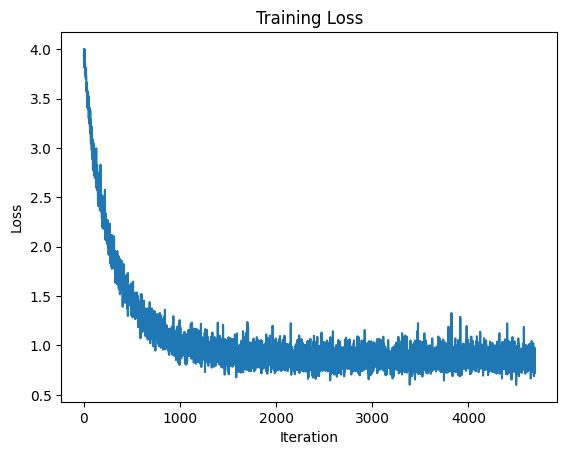

In [9]:
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.savefig("training_loss.png")

Test Accuracy of Regular Classifier: 55.57%
Test Accuracy (excluding deferrals): 87.23%
Deferral Accuracy: 85.02%
Overall Deferral Rate: 47.94%
Overall L2D Accuracy: 86.17%
Class 0: Accuracy (non-deferred) = 98.31%, Deferral Rate = 3.16%, Overall Accuracy = 95.20%
Class 1: Accuracy (non-deferred) = 89.07%, Deferral Rate = 62.91%, Overall Accuracy = 90.75%
Class 2: Accuracy (non-deferred) = 88.46%, Deferral Rate = 7.66%, Overall Accuracy = 81.69%
Class 3: Accuracy (non-deferred) = 0.00%, Deferral Rate = 92.67%, Overall Accuracy = 86.53%
Class 4: Accuracy (non-deferred) = 96.65%, Deferral Rate = 14.77%, Overall Accuracy = 82.38%
Class 5: Accuracy (non-deferred) = 0.00%, Deferral Rate = 83.97%, Overall Accuracy = 78.48%
Class 6: Accuracy (non-deferred) = 94.34%, Deferral Rate = 2.30%, Overall Accuracy = 92.17%
Class 7: Accuracy (non-deferred) = 0.00%, Deferral Rate = 96.60%, Overall Accuracy = 93.68%
Class 8: Accuracy (non-deferred) = 93.69%, Deferral Rate = 23.51%, Overall Accuracy = 71.

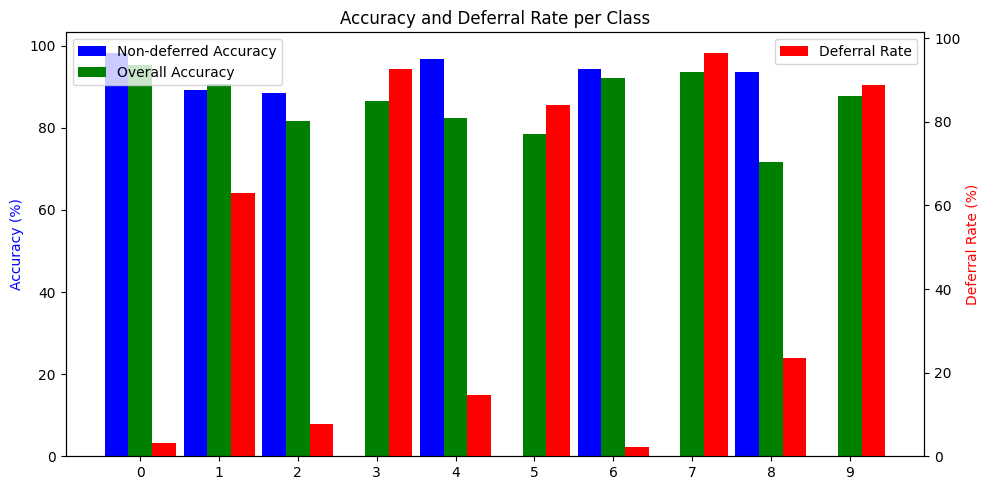

In [10]:
# eval 

all_outputs = []
all_labels = []
all_expert_labels = []

with torch.no_grad():
    for images, labels, expert_labels in test_loader:

        outputs = model(images)
        
        all_outputs.append(outputs)
        all_labels.append(labels)
        all_expert_labels.append(expert_labels)

all_outputs = torch.cat(all_outputs, dim=0)
all_labels = torch.cat(all_labels, dim=0)
all_expert_labels = torch.cat(all_expert_labels, dim=0)

l2d_eval = L2D_Eval(num_classes, all_outputs, all_labels, all_expert_labels, deferral_class_index, realizable_sm=True, tau=0.5)

model_report = l2d_eval.model_report()
per_class_report = l2d_eval.per_class_report()
l2d_eval.visualize_per_class_metrics()